Exploratory Data Analysis - Loggi Distrito Federal


---

1. Context:


This exploratory data analysis will be carried out based on logistics data from the startup Loggi, using the Loggi Benchmark for Urban Deliveries (BUD) project. This project contains data and code to solve typical problems faced by logistics companies, such as optimizing delivery routes and allocating deliveries to vehicles with limited capacity.

The data is synthesized from public sources such as IBGE and IPEA, representing the startup's daily challenges, especially related to its scale of operation. The focus of the analysis will be the Federal District, considering its variations in population density in three regions served by the startup.

Crucial questions about operational efficiency emerged:

1. Assess whether the number of distribution HUBs is sufficient.
2. Check whether the distribution of deliveries between the HUBs is balanced.

2. Packages and libraries:

In [1]:
import json
import geopy

import wget
import os
import zipfile
import shutil
import geopandas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

3. Loads:

In [2]:
# Path to the 'dados brutos' folder
pasta_dados_brutos = "./dados brutos"

# Loading JSON data from the Loggi Benchmark for Urban Deliveries (BUD) project
url_deliveries_json = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json"
data = pd.read_json(url_deliveries_json)

# Save the 'deliveries.json' file to the 'dados brutos' folder
data.to_json(os.path.join(pasta_dados_brutos, "deliveries.json"), orient="records")

# Loading the geocoded data from the nested 'deliveries' column
url_deliveries_geodata = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
deliveries_geodata_df = pd.read_csv(url_deliveries_geodata)
deliveries_geodata_df.to_csv(os.path.join(pasta_dados_brutos, "deliveries-geodata.csv"), index=False)

# Loading data referring to IBGE Federal District maps to the delivery map by region

# ZIP file URL
url_distrito_federal = "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip"

# ZIP file name
zip_file = os.path.join(pasta_dados_brutos, "distrito-federal.zip")

# Destination folder to extract the files
extract_folder = os.path.join(pasta_dados_brutos, "maps")

# Download the ZIP file
wget.download(url_distrito_federal, zip_file)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Copy the necessary files
shutil.copyfile(os.path.join(extract_folder, "LIM_Unidade_Federacao_A.shp"), os.path.join(pasta_dados_brutos, "distrito-federal.shp"))
shutil.copyfile(os.path.join(extract_folder, "LIM_Unidade_Federacao_A.shx"), os.path.join(pasta_dados_brutos, "distrito-federal.shx"))

# Loading the borders that will delimit the map
mapa = geopandas.read_file(os.path.join(pasta_dados_brutos, 'distrito-federal.shp'))
mapa = mapa.loc[[0]]


3. Knowing the data.

In [3]:
# Generating a dataframe from JSON files
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [4]:
# Conferindo quantas linhas há no dataframe inicial com colunas aninhadas
len(deliveries_df)

199

4. Cleaning and transformation stage.

4.1. Normalizing nested data from column 'origin'.

In [5]:
# Worked with the 'origin' column that has nested data through the 'normalize' method of the JSON library
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [6]:
# Returning the data to the original dataframe using Inner to maintain data consistency, based on the index
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [7]:
# Manipulating the dataframe for better reading
deliveries_df = deliveries_df.drop('origin', axis =1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


4.2. Normalizing the data in the 'deliveries' column.

In [8]:
# Manipulating the deliveries column (a list of nested data) using the Pandas explode method, generating a line for each element contained in the list
deliveries_explode_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_explode_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [9]:
# Structure normalization using the concat method to preserve the index and keep data consistent
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries':'delivery_size'}),
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries':'delivery_lat'})
], axis = 1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [10]:
# Checking how many rows there are in the dataframe after data normalization
len(deliveries_explode_df)

636149

In [11]:
# Returning the data to the original dataframe, this time using the Right method
deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df=pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


5. Data exploration.

In [12]:
# Checking the number of rows and columns in the dataframe
deliveries_df.shape

(636149, 8)

In [13]:
# Checking the dataframe columns
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [14]:
# Checking the range to know the ability to access and manipulate data within the dataframe using this index
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [15]:
# Checking the type of each column (Schema), values, memory used.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [16]:
# Analyzing the categorical columns of the dataframe, checking whether the names are unique and match the total quantity, in addition to observing the regions that are most frequent.
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [17]:
# Analyzing the categorical columns of the dataframe, observing data such as standard deviation of capacity and order size.
deliveries_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


Emergence of questions: Based on the analysis of the description of the categorical data, it is observed that in the 'vehicle_capacity' column, the average is 180 and the standard deviation is 0. Therefore, the delivery capacity is the same for ALL three regions of the Federal District. However, when analyzing the description of the categorical data, it was observed that the 'df-1' region represents almost 50% of deliveries. In this way, the possibility of better distributing this capacity to regions with a higher density of deliveries becomes evident. However, it is important to emphasize that it is too early to say this and that we need to delve deeper into the data analysis to reach a more precise conclusion.

In [18]:
# Checking for null values
deliveries_df.isnull().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

6. Data quality and enrichment.

In [19]:
# Removing duplicate values ​​from the columns of interest to apply geocoding to the latitudes and longitudes of the dataframe
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [20]:
# Evaluating structure and using the Nominatim API to carry out the geocoding process
geolocator = Nominatim(user_agent='matheusovsk')
location = geolocator.reverse('-15.657014, -47.802665')

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 13551965,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656915980217473",
  "lon": "-47.802644868369704",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

6.1. Applying Geopy to extract more data through geocoding on 'hub_lat' and 'hub_lng' columns.

In [21]:
# Applying the geocoder and creating a column with the extracted information
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ", " + hub_df['hub_lng'].astype(str)
hub_df ['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [22]:
# Taking the columns that contain the data of interest and normalizing the data using the 'normalize' method of the JSON library
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
print(hub_geodata_df.columns)

Index(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon', 'class',
       'type', 'place_rank', 'importance', 'addresstype', 'name',
       'display_name', 'boundingbox', 'address.road', 'address.residential',
       'address.suburb', 'address.town', 'address.municipality',
       'address.county', 'address.state_district', 'address.state',
       'address.ISO3166-2-lvl4', 'address.region', 'address.postcode',
       'address.country', 'address.country_code', 'address.neighbourhood',
       'address.city', 'address.shop', 'address.house_number'],
      dtype='object')


In [23]:
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,13551965,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,13548034,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,10766946,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [24]:
# Completing missing data within columns using a column with common data
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)
hub_geodata_df.head()


,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [25]:
# Adding the data obtained through geocoding in the 'hub_df' that contains the 'region' column
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [26]:
# # Returning everything to the initial dataframe with the 'inner' method through the 'region' column
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity',
                               'delivery_size', 'delivery_lng', 'delivery_lat' ]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


6.2. Due to the limitations of Nominatim and the amount of data in use, we will need a docker and install Nominatim locally to be able to apply geocoding, this way, I bring the already processed data in a csv file loaded in 'Loads'.

In [27]:
# Adding the data obtained through Nominatim and Docker installed locally into the initial dataframe with the 'inner' method through index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


7. Data quality.

In [28]:
# Collecting information from the dataframe after enrichment using geocoding
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [29]:
# Checking for null values
deliveries_df.isnull().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [30]:
# Getting the proportion of cities by dataframe size and sorting in descending order
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [31]:
# Obtaining the proportion of neighborhoods by the size of the dataframe and sorting in descending order
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

Emergence of questions: Based on the analysis of the neighborhoods column (delivery_suburb), we can notice that 'Brasília' is being counted as a neighborhood and that it represents the largest percentage within this data set. That way, you could take this into consideration to raise some reservations.

8. Data visualization.

In [32]:
# Checking how the map edges are organized
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [33]:
# Adding the information with the map borders to the 'hub_df' dataframe and generating a GeoDataFrame object to work as geospatial data
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [34]:
# Creating a new dataframe with the 'geopandas.GeoDataFrame' method from the initial dataframe and adding a 'geometry' column with latitude and longitude points

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy( deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


8.1. Plotting the delivery map in the Federal District.

In [35]:
pasta_graficos = "./graficos"

C:\Users\Matheus Rodrigues\AppData\Local\Temp\ipykernel_17472\2349747503.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


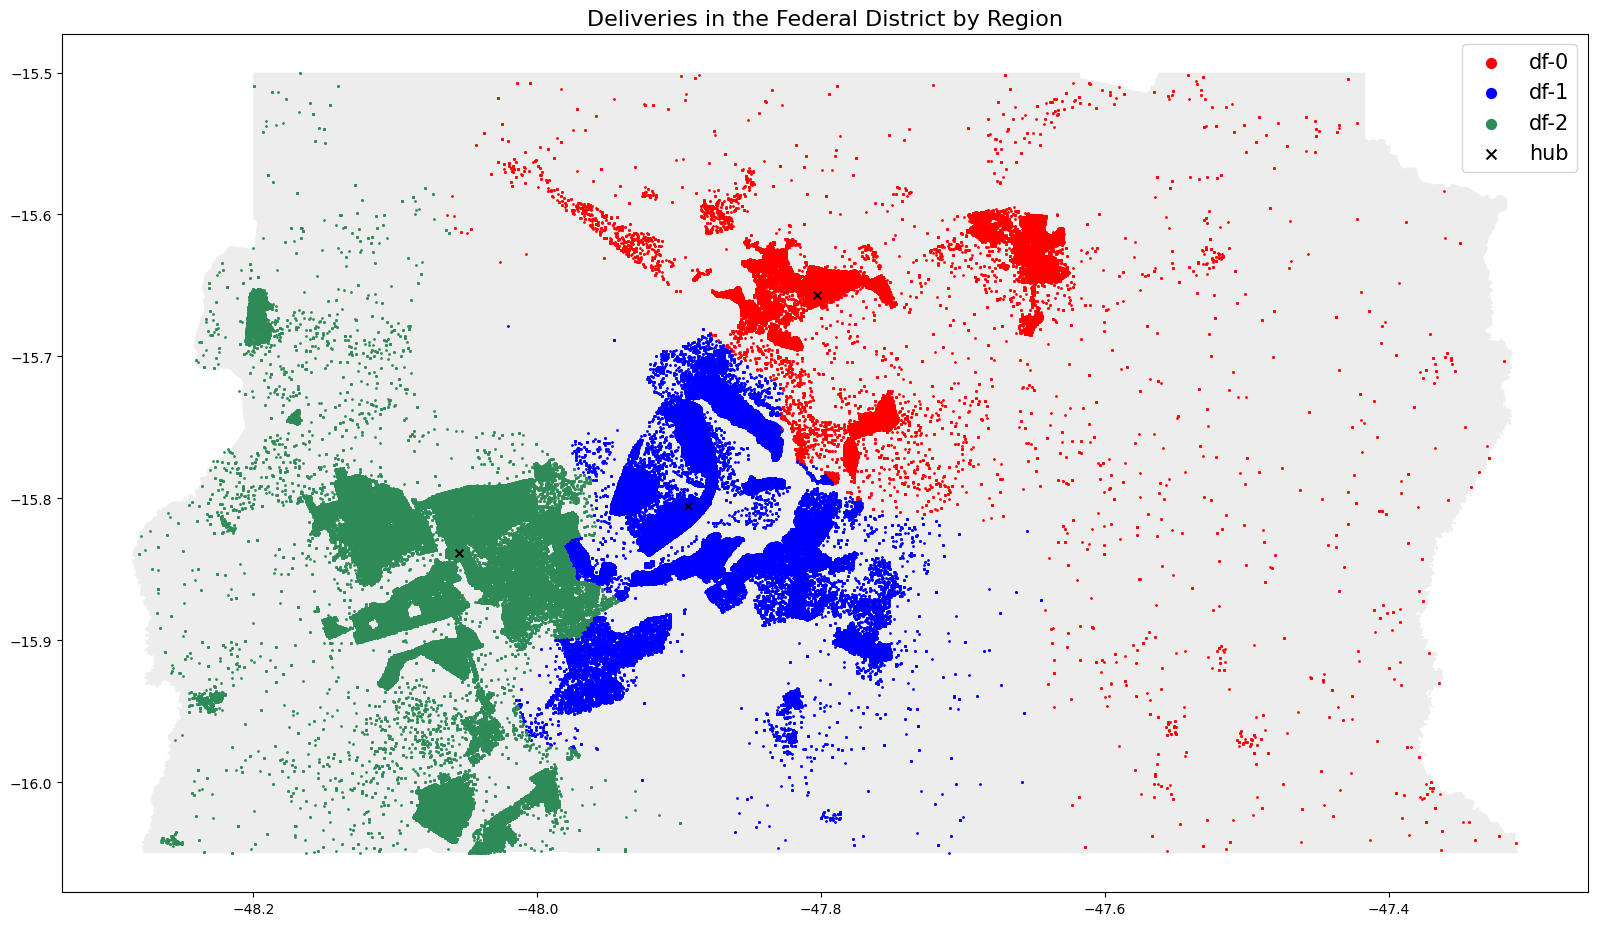

In [36]:
# Plotting the delivery map

# Creates empty plot
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot map of the federal district
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Delivery plot
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# Hub plot
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Subtitle plot 
plt.title("Deliveries in the Federal District by Region", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

# Save the plot in the 'graficos' folder
plt.savefig(os.path.join(pasta_graficos, "delivery_map.png"))

Insight 01:
 
 Considering the efficiency of delivery routes, deliveries are small, limited to 10kg, the distribution of hubs in the df-0 and df-1 regions can influence the efficiency of delivery routes significantly. In the df-0 region, where hubs are more widely spaced, optimizing routes can be crucial to reduce transportation time and cost between hubs and final destinations. This can be achieved by planning more direct routes or selecting vehicles better suited to handling long distances. On the other hand, in the df-1 region, where hubs are concentrated in the middle of the DF, delivery strategies can focus on taking advantage of this proximity to implement faster and more efficient deliveries, using smaller distribution centers or staged deliveries to optimize the transit time and improve delivery speed.

8.2. Plotting the 'boxplot' graph of the distribution of the size of deliveries in the regions of the Federal District

C:\Users\Matheus Rodrigues\AppData\Local\Temp\ipykernel_17472\4055358501.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='region', y='delivery_size', palette='Set3')


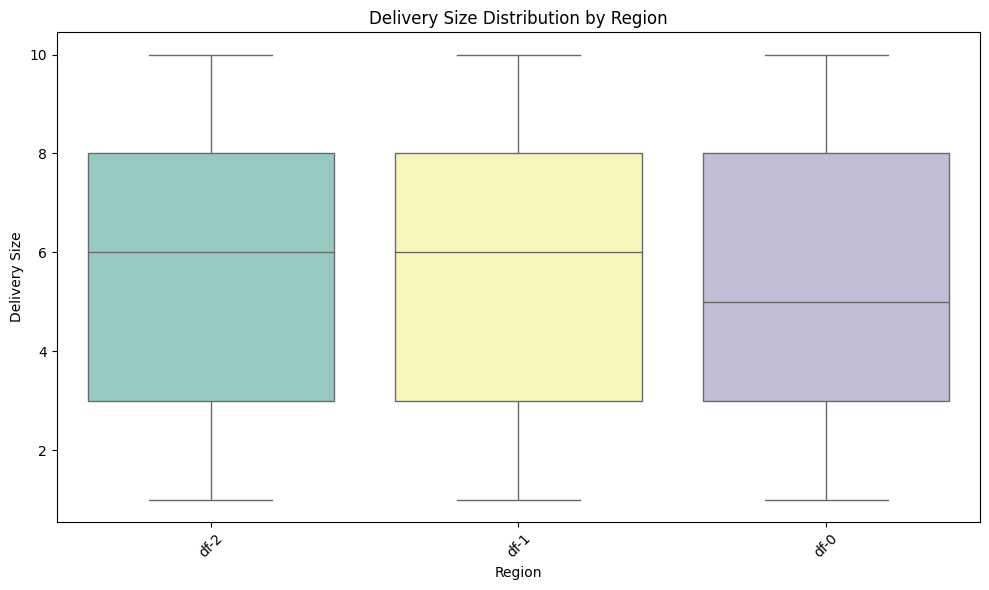

In [37]:
# Getting the columns of interest
data = deliveries_df[['delivery_size', 'region']]

# Plotting the boxplot graph
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='region', y='delivery_size', palette='Set3')
plt.xlabel('Region')
plt.ylabel('Delivery Size')
plt.title('Delivery Size Distribution by Region')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot in the 'graficos' folder
plt.savefig(os.path.join(pasta_graficos, "deliverysize_region.png"))

Insight 02: 

Given the variability in the distribution of delivery sizes by region, especially the concentration of larger deliveries in high demand areas, as observed in df-1 and df-2, an advantageous strategy would be to distribute delivery hubs to these areas. This is reinforced by the median size of deliveries, which, in df-1 and df-2, is close to 6, indicating consistency in the types or volumes of items delivered. On the other hand, at df-0, the median probably at 5 suggests a more dispersed distribution, with greater variability in the types or volumes of items delivered. Therefore, distributing delivery hubs to areas with the highest demand and heaviest deliveries can improve logistics efficiency, reducing transport times and optimizing the use of delivery resources. This approach can contribute to a more effective and economical operation, better meeting the needs of regions with the highest delivery demand and ensuring a balanced distribution of delivery capacity.

8.2. Plotting the graph of the proportion of deliveries by region.

In [38]:
# Aggregating the data of interest
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


C:\Users\Matheus Rodrigues\AppData\Local\Temp\ipykernel_17472\2342066502.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico_entrega_por_regiao = sns.barplot(data=data, x='region', y='proportion', ci=None, palette='pastel')
C:\Users\Matheus Rodrigues\AppData\Local\Temp\ipykernel_17472\2342066502.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico_entrega_por_regiao = sns.barplot(data=data, x='region', y='proportion', ci=None, palette='pastel')


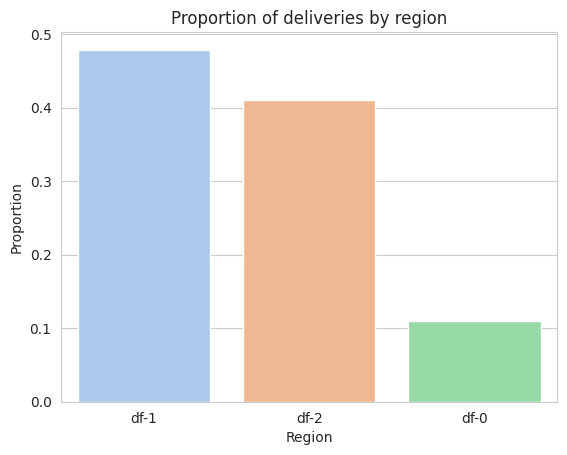

In [39]:
# Rename the count column to 'proportion'
data.rename(columns={0: 'proportion'}, inplace=True)

# Plotting the graph of delivery proportion by region
with sns.axes_style('whitegrid'):
    grafico_entrega_por_regiao = sns.barplot(data=data, x='region', y='proportion', ci=None, palette='pastel')
    grafico_entrega_por_regiao.set(title='Proportion of deliveries by region', xlabel='Region',  ylabel='Proportion');

# Save the plot in the 'graficos' folder
plt.savefig(os.path.join(pasta_graficos, "prop_deliveries_byregion.png"))

Insight 03:

 When observing that all regions (df-0, df-1 and df-2) have the same delivery capacity of 180 units, however the df-0 region has a significantly lower proportion of deliveries (11.02%), while df-1 has the highest proportion of deliveries (47.90%), the question arises whether it would not be more logical to reallocate delivery capacity to where there is more demand. This may indicate that the df-0 region may not need as much capacity due to low demand or that deliveries may be longer in this region, resulting in fewer deliveries. Therefore, it would be advantageous to consider a redistribution of delivery capacity to better meet the needs of regions with the highest demand, thus optimizing the efficiency of the delivery system.

9. Conclusion of insights generated:

Detailed analysis of delivery data has revealed important patterns and trends that can significantly influence the efficiency and effectiveness of the logistics system. It became clear that the distribution of delivery hubs plays a key role in optimizing delivery routes, especially considering the variability in demand and geographic distribution of deliveries. Furthermore, consideration of delivery capacity in relation to observed demand in each region suggests the need for a more flexible and adaptive approach to allocating delivery resources. In df-0, where hubs are more widely spaced, optimizing routes is crucial to reduce transportation time and cost, while in df-1, where hubs are concentrated, delivery strategies can be implemented to take advantage of proximity and improve delivery speed. It was observed that all regions have the same delivery capacity, but the proportions of deliveries vary significantly. This suggests the possibility of redistributing delivery capacity to better meet the needs of regions with greater demand, optimizing the efficiency of the delivery system. This holistic, data-driven approach highlights the importance of detailed analysis to ensure customer satisfaction and operational efficiency.